# Predicting Lung Cancer Survival Time

predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data

### $\color{green}{\text{ Importing Libraries }}$ 

In [1]:
import pandas as pd
import numpy as np
import missingno
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import HTML

## $\color{red}{\text{ Exploring Data}}$

## X Train 

## $\color{Blue}{\text {Features Exploration }}$

In [2]:
train_path = '/home/zahrael97/Downloads/challenge file/xtrain/data_Q0G7b5t'
#Radiomic Training data 
df_Radiomics_train = pd.read_csv(train_path + '/features/radiomics.csv',skiprows=[0,2], header=[0],index_col=0)
#Clinical Training data 
df_clinical_train = pd.read_csv(train_path + '/features/clinical_data.csv',index_col=0)

In [3]:
df_clinical_train.head() #the 5 first lines 

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


## What missing values are there?

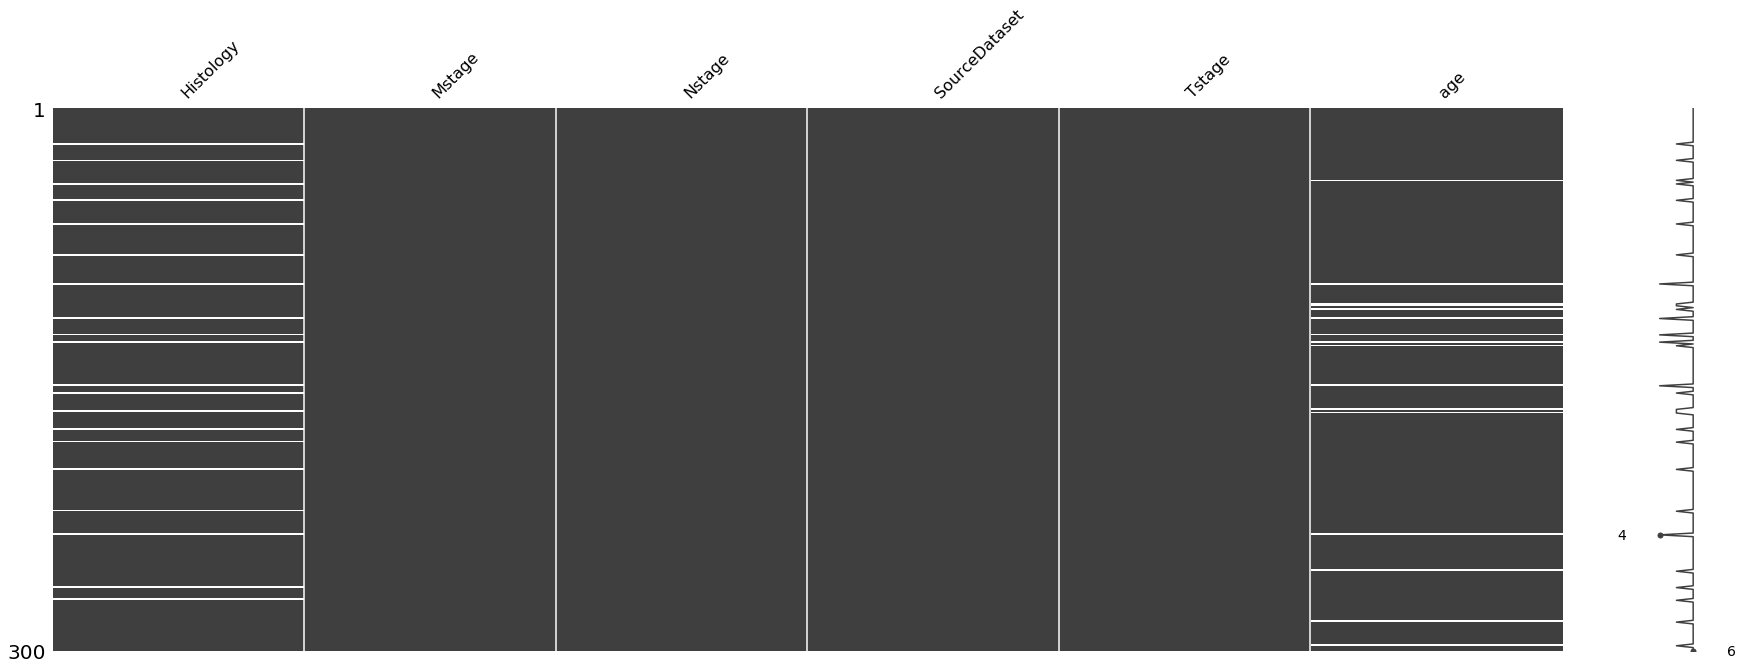

In [4]:
missingno.matrix(df_clinical_train, figsize = (30,10))

In [5]:
#We will use the age feature after filling the NaN values 
df_clinical_train = df_clinical_train.fillna(df_clinical_train.mean())

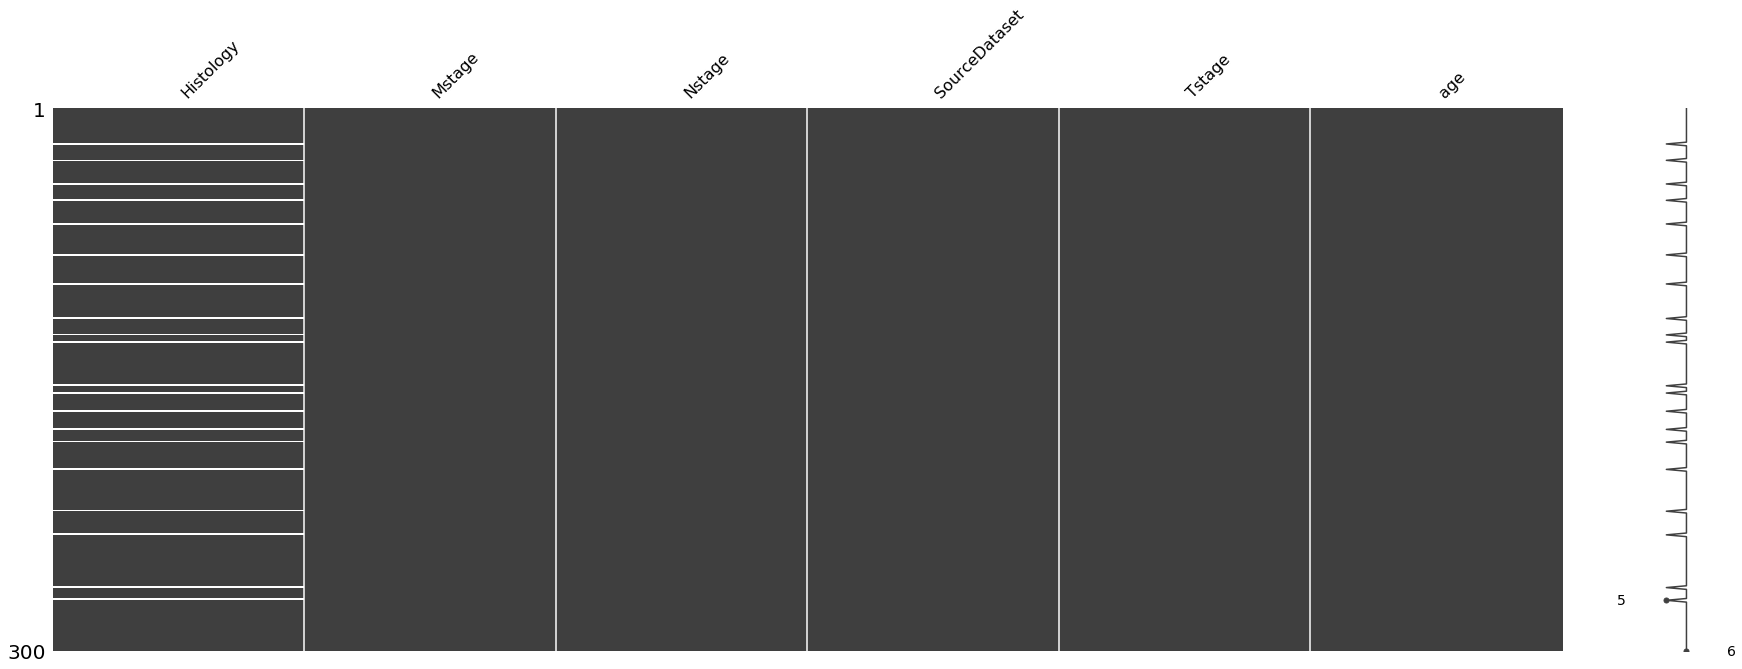

In [6]:
missingno.matrix(df_clinical_train, figsize = (30,10))

We will ignore the Histology feature

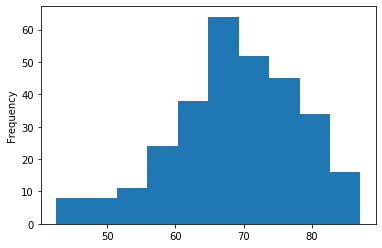

In [7]:
df_clinical_train.age.plot.hist()

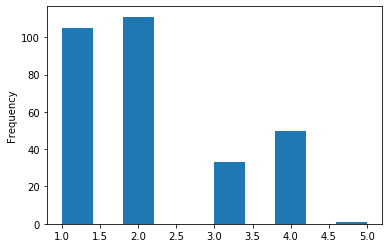

In [8]:
df_clinical_train.Tstage.plot.hist()

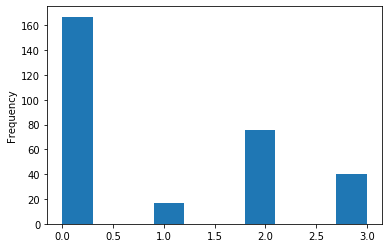

In [9]:
df_clinical_train.Nstage.plot.hist()

## Feature Encoding
Now we will encode the SourceDataset feature so it will be  ready to be used with our machine learning models.



In [10]:
encoder = LabelEncoder()
encoder.fit(df_clinical_train["SourceDataset"] )
df_clinical_train["SourceDataset"]= encoder.transform(df_clinical_train["SourceDataset"])

In [11]:
df_Radiomics_train.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


In [12]:
df_Radiomics_train.isnull().sum().sum()

0

### Features Used 

- Tumor sphericity, a measure of the roundness of the shape of the tumor region relative to a sphere, regardless its dimensions (size)
- The tumor's surface to volume ratio is a measure of the compactness of the tumor, related to its size  
- The tumor's maximum 3d diameter The biggest diameter measurable from the tumor volume 
- The dataset of origin
- The N-tumoral stage grading of the tumor describing nearby (regional) lymph nodes involved
- The tumor's joint entropy, specifying the randomness in the image pixel values
- age
- Tstage
- The tumor's inverse different, a measure of the local homogeneity of the tumor
-  The tumor's inverse difference moment is another measurement of the local homogeneity of the tumor

In [13]:
df_X_train = pd.concat([df_Radiomics_train[["original_shape_Sphericity", "original_shape_SurfaceVolumeRatio", "original_shape_Maximum3DDiameter","original_firstorder_Entropy",
"original_glcm_Id","original_glcm_Idm"]],df_clinical_train[["SourceDataset","Nstage","Tstage","age"]]], axis=1)

## y Train

In [14]:
ytrain_path = '/home/zahrael97/Downloads/challenge file/ytrain'
df_y = pd.read_csv( ytrain_path+ '/output_VSVxRFU.csv', index_col=0)
p0 = df_y.loc[202]
print("p0.Event", p0.Event)
print("p0.SurvivalTime", p0.SurvivalTime)

p0.Event 0
p0.SurvivalTime 1378


In [15]:
df_y.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


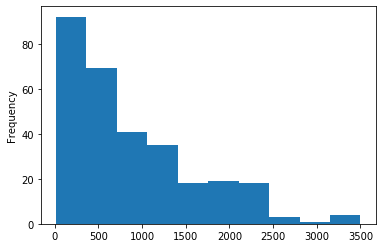

In [16]:
df_y.SurvivalTime.plot.hist()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualise the counts of SibSp and the distribution of the values
# against Survived
#plot_count_dist(df_y, 
#                bin_df=df_bin, 
#                label_column='SurvivalTime', 
#                target_column='Event', 
#                figsize=(10, 5))

## $\color{red}{\text {Start Building Machine Learning Models}}$
Now our data has been manipulating and converted to numbers, we can run the machine learning Models.

## CoxPHFitter 

In [18]:
cph = CoxPHFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [19]:
cph.print_summary()

 Although using Cox proportional hazard model has come to the fore by most researchers in medical and cancer fields, results of accelerated failure-time models have often been more valid and have had minor bias since these models have better fitness in similar conditions due to a specific statistical distribution for the survival time and their not having need to PH assumption. Accelerated failure-time models will also be reliable alternatives to Cox proportional hazard model where this assumption is not made. In addition, accelerated failure-time models may offer some benefits.
 Based on asymptotic results, accelerated failure-time models lead to more efficient parameters than proportional hazard model. With a reduction in sample size, relative efficiency may further change in favor of accelerated failure-time models. When empirical information is adequate, accelerated failure-time models can prepare some insights into the form of the baseline hazard.

From paper : A Comparison between Accelerated Failure-time and Cox Proportional Hazard Models in Analyzing the Survival of Gastric Cancer Patients
### $\color{red}{\text { Let's try it out}}$

## WeibullAFTFitter

In [20]:
Wei = WeibullAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [21]:
Wei.print_summary()

## LogNormalAFTFitter 

In [22]:
log = LogNormalAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [23]:
log.print_summary()

## LogLogisticAFTFitter

In [24]:
logistic = LogLogisticAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [25]:
logistic.print_summary

<bound method ParametricRegressionFitter.print_summary of <lifelines.LogLogisticAFTFitter: fitted with 300 total observations, 138 right-censored observations>>

## Concordance_index

In [26]:
df = pd.concat([df_X_train, df_y], axis = 1)

In [27]:
cox_cv_result = k_fold_cross_validation(cph, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('CoxPHFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

CoxPHFitter C-index(cross-validation) =  0.6737043662778599


In [28]:
cox_cv_result = k_fold_cross_validation(Wei, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('WeibullAFTFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

WeibullAFTFitter C-index(cross-validation) =  0.6936897091476417


In [29]:
cox_cv_result = k_fold_cross_validation(log, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('LogNormalAFTFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

LogNormalAFTFitter C-index(cross-validation) =  0.700731281591308


In [30]:
cox_cv_result = k_fold_cross_validation(logistic, df, duration_col='SurvivalTime', event_col='Event', k=5)
print(' C-index(cross-validation) = ', np.mean(cox_cv_result))

 C-index(cross-validation) =  0.6790343487530152


## $\color{red}{\text{ Submission}}$

## X Test

In [31]:
test_path = '/home/zahrael97/Downloads/challenge file/xtest/data_9Cbe5hx'
df_Radiomics_test = pd.read_csv(test_path +'/features/radiomics.csv',skiprows=[0,2], header=[0],index_col=0)
df_clinical_test = pd.read_csv(test_path + '/features/clinical_data.csv',index_col=0)

In [32]:
#fill the NaN values of age 
df_clinical_test = df_clinical_test.fillna(df_clinical_test.mean())

In [33]:
encoder = LabelEncoder()
encoder.fit(df_clinical_test["SourceDataset"])
df_clinical_test["SourceDataset"] = encoder.transform(df_clinical_test["SourceDataset"])

In [34]:
df_X_test = pd.concat([df_Radiomics_test[["original_shape_Sphericity", "original_shape_SurfaceVolumeRatio", "original_shape_Maximum3DDiameter","original_firstorder_Entropy",
"original_glcm_Id","original_glcm_Idm"]],df_clinical_test[["SourceDataset","Nstage","Tstage","age"]]], axis=1)

In [35]:
#df = pd.concat([df_X_train, df_y], axis = 1)
#concordance_index(df['SurvivalTime'], -cph.predict_partial_hazard(df), df['Event'])

## Lifetime prediction

In [36]:
lifetime_prediction = log.predict_expectation(df_X_test)
lifetime_prediction.columns = ['SurvivalTime']
lifetime_prediction.index.names = ['PatientID']
lifetime_prediction['Event'] = 'NaN'

In [37]:
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

lifetime_prediction.to_csv('submission.csv')

create_download_link(filename='submission.csv')

## $\color{black}{\text{ Still working on it }}$

### Exploring Images data

In [38]:
archive = np.load(train_path + '/images/patient_003.npz')
scan = archive['scan']
mask = archive['mask']
#print(scan.shape)

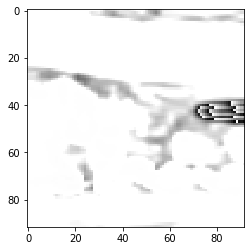

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#plt.figure()
#plt.ion()

#archive.shape
#imshow(img)
#plt.imshow(Image.fromarray(scan, 'RGBA'))
#plt.imshow(Image.fromarray(scan, 'CMYK'))
#plt.imshow(Image.fromarray(mask, 'LA'))
plt.imshow(Image.fromarray(scan, 'LA'))

In [40]:
def logprediction(y_true_times) :
    y_true_times.columns = ['SurvivalTime']
    y_true_times.index.names = ['PatientID']
    y_true_times['Event'] = 0
    return(y_pred) 

Challenge C-index

In [41]:
from metrics_t9gbvr2 import cindex

### Loading 